In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import time
import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split    #to split train/validation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import string
from wordcloud import WordCloud 
from sklearn.svm import LinearSVC
from sklearn import metrics


Data contains the following 6 fields:

target: the polarity of the tweet (0 = negative, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

In [2]:
DATASET_COLUMNS=['polarity','ids','date','query','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('D:\dataset.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)


,polarity,ids,date,query,user,text
50298,0,1678439824,Sat May 02 06:42:51 PDT 2009,NO_QUERY,daverage,Turns out I am a 34 waist and a 36 arse! Fed u...
860170,4,1676285418,Fri May 01 21:36:05 PDT 2009,NO_QUERY,aaronapplepie,The Devil Wears Prada
1177751,4,1981471439,Sun May 31 09:13:22 PDT 2009,NO_QUERY,irishgirl75,OMG I am re-reading the email - Joe says &quot...
251679,0,1983538746,Sun May 31 13:20:59 PDT 2009,NO_QUERY,SMPsFairyDust,Had a great SMP family day yesterday and today...
614423,0,2225860403,Thu Jun 18 11:14:12 PDT 2009,NO_QUERY,1rdreamer,@Ash1r that happened to me this morning so I c...


In [3]:
df.head(10)

,polarity,ids,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [4]:
string1 = "Columns are: "
for col in df.columns:
    string1 = string1 + col + ", "
print(string1)
print('Length of data is', len(df))
print("Shape of the data: ", df.shape)
print("\n***************Data information***************\n")
print(df.info())
if(np.sum(df.isnull().any(axis=1)) == 0):
    print("\n\n****************************************************\n\n There are no Null values in our data")
else:
    print("\n\n****************************************************\n\n There are Null values in our data")

Columns are: polarity, ids, date, query, user, text, 
Length of data is 1600000
Shape of the data:  (1600000, 6)

***************Data information***************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   ids       1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None


****************************************************

 There are no Null values in our data


In [5]:
#check the unique values in columns polarity
df['polarity'].unique()

array([0, 4], dtype=int64)

Try to visualise our dataset

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

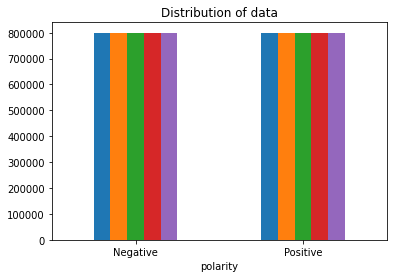

In [6]:
ax = df.groupby('polarity').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

We have a 800000 negative examples and 800000 positive examples


<AxesSubplot:xlabel='polarity', ylabel='count'>

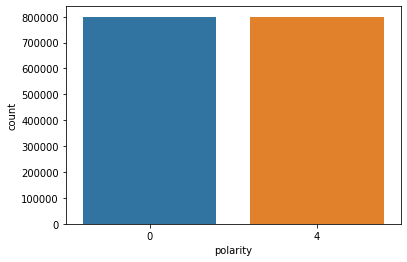

In [7]:
polarity0 = len(df.loc[df['polarity'] == 0])
polarity4 = len(df.loc[df['polarity'] == 4])
print("We have a " + str(polarity0) + " negative examples and " + str(polarity4) + " positive examples")
sns.countplot(x='polarity', data=df)

Data preprocessing

In [8]:
dataset = df[['polarity','text']]
# Replacing the values to ease understanding.
dataset['polarity'] = dataset['polarity'].replace(4,1)
text, polarity = list(dataset['text']), list(dataset['polarity'])

C:\Users\alyti\AppData\Local\Temp\ipykernel_15508\1533758327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['polarity'] = dataset['polarity'].replace(4,1)


In [9]:
print(dataset)

         polarity                                               text
0               0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1               0  is upset that he can't update his Facebook by ...
2               0  @Kenichan I dived many times for the ball. Man...
3               0    my whole body feels itchy and like its on fire 
4               0  @nationwideclass no, it's not behaving at all....
...           ...                                                ...
1599995         1  Just woke up. Having no school is the best fee...
1599996         1  TheWDB.com - Very cool to hear old Walt interv...
1599997         1  Are you ready for your MoJo Makeover? Ask me f...
1599998         1  Happy 38th Birthday to my boo of alll time!!! ...
1599999         1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


Stop words: https://www.englishbix.com/stop-words-list/
https://github.com/igorbrigadir/stopwords/blob/master/en/terrier.txt

In [10]:
#Defining set containing all stopwords in English.
stopwordlist = ['a','ourselves','about','out','above','over','after','own','again','same', 'against',"shan't",
                'all','she','am',"she'd",'an',"she'll",'and',"she's",'any','should','are',"shouldn't","aren't",'so',
                'as','some','at','such','be','than','because','that','been',"that's",'before','the','being','their',
                'below','theirs','between','them','both','themselves','but','then','by','there',"can't","there's",'cannot',
                'these','could','they',"couldn't","they'd",'did',"they'll","didn't","they're",'do',"they've",'does','this',
                "doesn't",'those','doing','through',"don't",'to','down','too','during','under','each','until','few','up',
                'for','very','from','was','further',"wasn't",'had','we',"hadn't","we'd",'has', "we'll","hasn't","we're",'have',
                "we've","haven't",'were','having',"weren't",'he','what',"he'd","what's","he'll",'when',"he's","when's", 
                'her','where','here',"where's","here's",'which','hers','while','herself','who','him',"who's",'himself',
                'whom','his','why','how',"why's","how's",'with','i',"won't","i'd",'would',"i'll","wouldn't","i'm",
                'you',"i've","you'd",'if',"you'll",'in',"you're",'into',"you've",'is','your',"isn't",'yours','it',
                'yourself',"it's",'yourselves','its','nor','itself','not',"let's",'of','me','off','more','on','most',
                'once',"mustn't",'only','my','or','myself','other','no','ought','ours','our', 'x','y','your','yours',
                'yourself','yourselves','you','yond','yonder','yon','ye','yet','z','zillion','j','u','umpteen','usually',
                'us','username','uponed','upons','uponing','upon','ups','upping','upped','up','unto','until','unless',
                'unlike','unliker','unlikest','under','underneath','use','used','usedest','r','rath','rather','rathest',
                'rathe','re','relate','related','relatively','regarding','really','res','respecting','respectively','q',
                'quite','que','qua','n','neither','neaths','neath','nethe','nethermost','necessary','necessariest',
                'necessarier','never','nevertheless','nigh','nighest','nigher','nine','noone','nobody','nobodies',
                'nowhere','nowheres','no','noes','nor','nos','none','not','notwithstanding','nothings',
                'nothing','nathless','natheless','t','ten','tills','till','tilled','tilling','to','towards','toward',
                'towardest','towarder','together','too','thy','thyself','thus','than','that','those','thou','though',
                'thous','thouses','thoroughest','thorougher','thorough','thoroughly','thru','thruer','thruest','thro',
                'through','throughout','throughest','througher','thine','this','thises','they','thee','the','then',
                'thence','thenest','thener','them','themselves','these','therer','there','thereby','therest','thereafter',
                'therein','thereupon','therefore','their','theirs','thing','things','three','two','o','oh','owt','owning',
                'owned','own','owns','others','other','otherwise','otherwisest','otherwiser','of','often','oftener',
                'oftenest','off','offs','offest','one','ought','oughts','our','ours','ourselves','ourself','out','outest',
                'outed','outwith','outs','outside','over','overallest','overaller','overalls','overall','overs','or','orer',
                'orest','on','oneself','onest','ons','onto','a','atween','at','athwart','atop','afore','afterward',
                'afterwards','after','afterest','afterer','ain','an','any','anything','anybody','anyone','anyhow',
                'anywhere','anent','anear','and','andor','another','around','ares','are','aest','aer','against',
                'again','accordingly','abaft','abafter','abaftest','abovest','above','abover','abouter','aboutest',
                'about','aid','amidst','amid','among','amongst','apartest','aparter','apart','appeared','appears',
                'appear','appearing','appropriating','appropriate','appropriatest','appropriates','appropriater',
                'appropriated','already','always','also','along','alongside','although','almost','all','allest',
                'aller','allyou','alls','albeit','awfully','as','aside','asides','aslant','ases','astrider',
                'astride','astridest','astraddlest','astraddler','astraddle','availablest','availabler','available',
                'aughts','aught','vs','v','variousest','variouser','various','via','viz','very','veriest','verier','versus',
                'k','g','go','gone','good','got','gotta','gotten','get','gets','getting','b','by','byandby','bist','both',
                'but','buts','be','beyond','because','became','becomes','become','becoming','becomings','becominger',
                'becomingest','behind','behinds','before','beforehand','beforehandest','beforehander','bettered','betters',
                'better','bettering','betwixt','between','beneath','been','below','besides','beside','m','my','myself',
                'mucher','muchest','much','must','musts','musths','musth','main','make','mayest','many','mauger','maugre',
                'me','meanwhiles','meanwhile','mostly','most','moreover','more','might','mights','midst','midsts','h',
                'huh','humph','he','hers','herself','her','hereby','herein','hereafters','hereafter','hereupon',
                'hence','hadst','had','having','haves','have','has','hast','hardly','hae','hath','him','himself',
                'hither','hitherest','hitherer','his','however','how','howbeit','howdoyoudo',
                'hoos','hoo','w','woulded','woulding','would','woulds','was','wast','we','wert','were','with',
                'withal','without','within','why','what','whatever','whateverer','whateverest','whatsoeverer',
                'whatsoeverest','whatsoever','whence','whencesoever','whenever','whensoever','when','whenas',
                'whether','wheen','whereto','whereupon','wherever','whereon','whereof','where','whereby','wherewithal',
                'wherewith','whereinto','wherein','whereafter','whereas','wheresoever','wherefrom','which','whichever',
                'whichsoever','whilst','while','whiles','whithersoever','whither','whoever','whosoever','whoso','whose',
                'whomever','s','syne','syn','shalling','shall','shalled','shalls','shoulding','should','shoulded',
                'shoulds','she','sayyid','sayid','said','saider','saidest','same','samest','sames','samer','saved',
                'sans','sanses','sanserifs','sanserif','so','soer','soest','sobeit','someone','somebody','somehow',
                'some','somewhere','somewhat','something','sometimest','sometimes','sometimer','sometime','several',
                'severaler','severalest','serious','seriousest','seriouser','senza','send','sent','seem','seems',
                'seemed','seemingest','seeminger','seemings','seven','summat','sups','sup','supping','supped','such',
                'since','sine','sines','sith','six','stop','stopped','p','plaintiff','plenty','plenties','please',
                'pleased','pleases','per','perhaps','particulars','particularly','particular','particularest',
                'particularer','pro','providing','provides','provided','provide','probably','l','layabout',
                'layabouts','latter','latterest','latterer','latterly','latters','lots','lotting','lotted',
                'lot','lest','less','ie','ifs','if','i','info','information','itself','its','it','is','idem',
                'idemer','idemest','immediate','immediately','immediatest','immediater','in','inwards','inwardest',
                'inwarder','inward','inasmuch','into','instead','insofar','indicates','indicated','indicate','indicating',
                'indeed','inc','f','fact','facts','fs','figupon','figupons','figuponing','figuponed','few','fewer','fewest',
                'frae','from','failing','failings','five','furthers','furtherer','furthered','furtherest','further',
                'furthering','furthermore','fourscore','followthrough','for','forwhy','fornenst','formerly','former',
                'formerer','formerest','formers','forbye','forby','fore','forever','forer','fores','four','d','ddays',
                'dday','do','doing','doings','doe','does','doth','downwarder','downwardest','downward','downwards',
                'downs','done','doner','dones','donest','dos','dost','did','differentest','differenter','different',
                'describing','describe','describes','described','despiting','despites','despited','despite','during',
                'c','cum','circa','chez','cer','certain','certainest','certainer','cest','canst','cannot','cant',
                'cants','canting','cantest','canted','co','could','couldst','comeon','comeons','concerning',
                'concerninger','concerningest','consequently','considering','e','eg','eight','either','even',
                'evens','evenser','evensest','evened','evenest','ever','everyone','everything','everybody',
                'everywhere','every','ere','each','et','etc','elsewhere','else','ex','excepted','excepts','except',
                'excepting','exes','enough', "im"]
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [11]:
#Cleaning and removing the above stop words list from the tweet text
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
pd.DataFrame(dataset['text']).head(20)

C:\Users\alyti\AppData\Local\Temp\ipykernel_15508\320078809.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))


,text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, b..."
1,upset update Facebook texting it... cry result...
2,@Kenichan I dived times ball. Managed save 50%...
3,whole body feels itchy like fire
4,"@nationwideclass no, behaving all. mad. here? ..."
5,@Kwesidei whole crew
6,Need hug
7,"@LOLTrish hey long time see! Yes.. Rains bit ,..."
8,@Tatiana_K nope
9,@twittera muera ?


In [12]:
def clean(text):
    processedText = []
    wordLemm = nltk.WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in text:
        tweet = tweet.lower()

        tweet = re.sub(urlPattern,'',tweet)
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        tweet = re.sub(userPattern,'', tweet)        
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
                if len(word)>1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [13]:
import time
t = time.time()
processedtext = clean(text)
print(f'Total Time taken for Preprocessing: {round(time.time()-t)} seconds')

Total Time taken for Preprocessing: 136 seconds


In [14]:
processedtext

['aww that bummer you shoulda got david carr of third day to do it EMOJIwink ',
 'is upset that he can update his facebook by texting it and might cry a result school today also blah ',
 'dived many time for the ball managed to save 50 the rest go out of bound ',
 'my whole body feel itchy and like it on fire ',
 'no it not behaving at all mad why am here because can see you all over there ',
 'not the whole crew ',
 'need hug ',
 'hey long time no see yes rain bit only bit lol fine thanks how you ',
 'nope they didn have it ',
 'que me muera ',
 'spring break in plain city it snowing ',
 'just re pierced my ear ',
 'couldn bear to watch it and thought the ua loss wa embarrassing ',
 'it it count idk why did either you never talk to me anymore ',
 'would ve been the first but didn have gun not really though zac snyder just doucheclown ',
 'wish got to watch it with you miss you and how wa the premiere ',
 'hollis death scene will hurt me severely to watch on film wry is director cut no

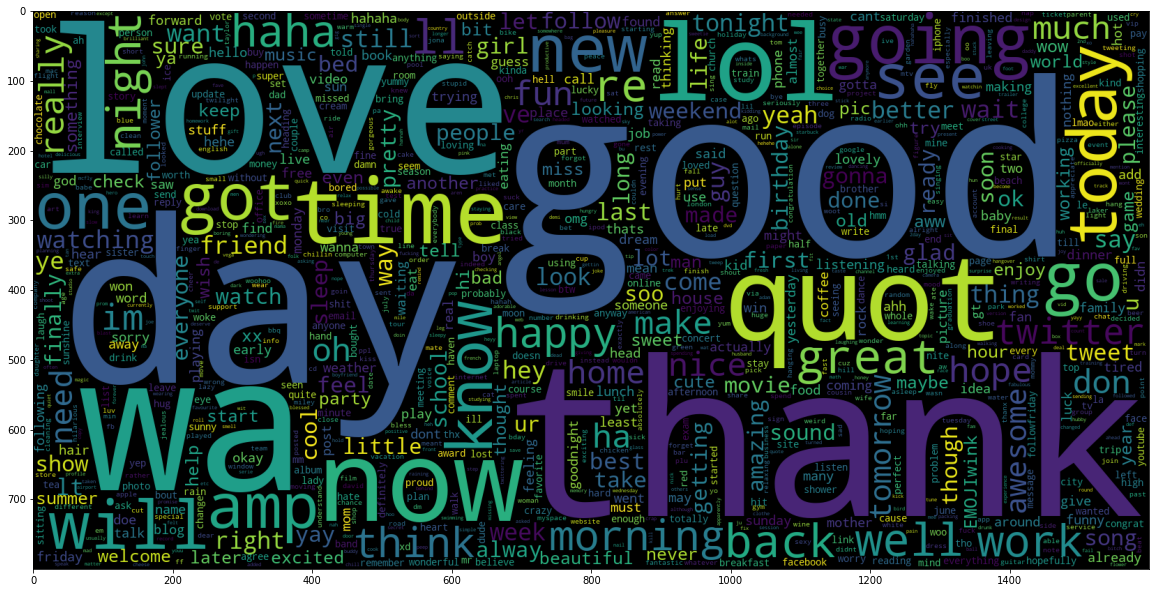

In [15]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

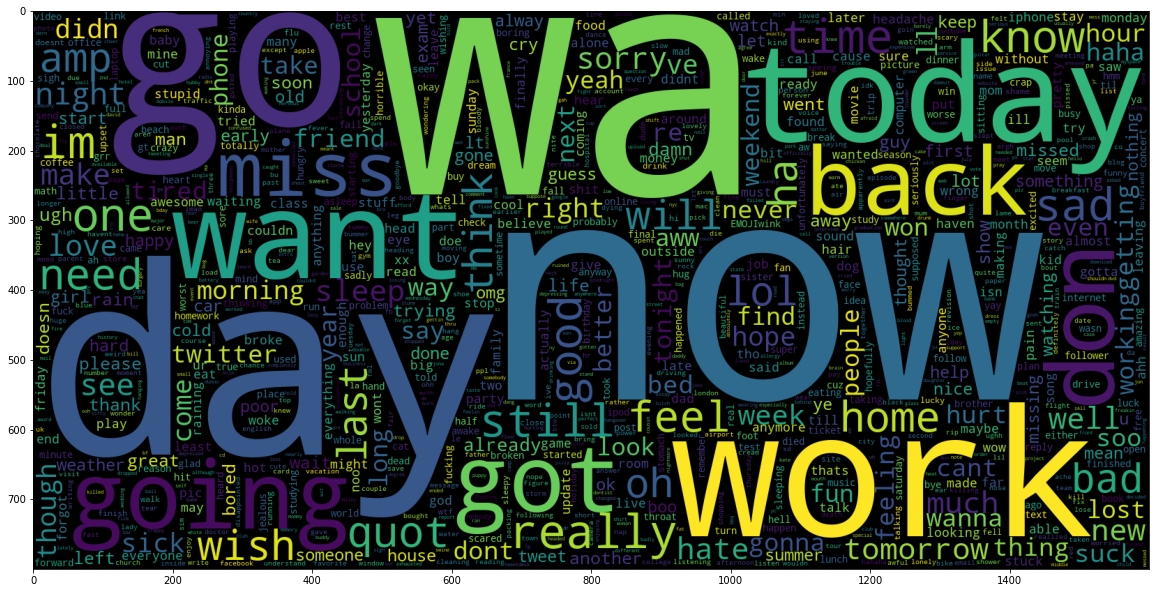

In [16]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, polarity,
                                                    test_size = 0.2, random_state = 0)
print(f'Data Split Completed.')

Data Split Completed.


In [18]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectorizer fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectorizer fitted.
No. of feature_words:  500000


In [19]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed According to vector.')

Data Transformed According to vector.


In [20]:
def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(clean(text))
    sentiment = model.predict(textdata)
    y_pred = []
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        y_pred.append(pred)
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [21]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    print("Accuracy ", round(metrics.accuracy_score(y_test, y_pred), 3))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred))
    
    categories  = ['Negative','Positive']

    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = [value for value in cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Greens',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted ", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual "   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion ", fontdict = {'size':18}, pad = 20)

Accuracy  0.814
              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159815
           1       0.81      0.82      0.82    160185

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



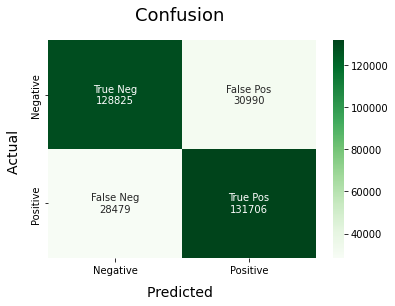

In [22]:
#Model-1(SVM (Support Vector Machine))
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

Accuracy  0.825
              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159815
           1       0.82      0.83      0.83    160185

    accuracy                           0.82    320000
   macro avg       0.83      0.82      0.82    320000
weighted avg       0.83      0.82      0.82    320000



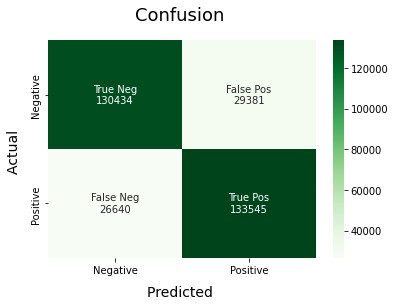

In [23]:
#Model 2 (LogisticRegression)
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

As a result, we do not use tf idf vectoriser to our data before using this model, but our data there using count vectoriser. After this we can use BNB model to train and predict.

Accuracy  0.78
              precision    recall  f1-score   support

           0       0.78      0.78      0.78    159815
           1       0.78      0.79      0.78    160185

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



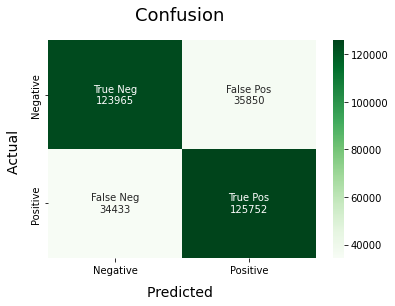

In [24]:
cv = CountVectorizer()
x = cv.fit_transform(processedtext)
X_train, X_test, y_train, y_test = train_test_split(x, polarity,
                                                    test_size = 0.2, random_state = 0)
BNBmodel = BernoulliNB(binarize=0.0)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
